# Прогнозирование вероятности дефолта заемщика

Задача: построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. 

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [2]:
#фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы!
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Импорт данных

In [3]:
DATA_DIR = '../input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [5]:
print('df_train', df_train.shape)
print('df_test', df_test.shape)

df_train (73799, 20)
df_test (36349, 19)


# Анализ и подготовка данных

## 1. Первичный осмотр

Описание признаков:

client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту  

In [6]:
data.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,NaN
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,NaN
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

20 признаков:  
-5 категориальных  
-5 бинарных  
-7 числовых   
-1 временной "app_date"  
-1 целевая переменная "default"   
-1 искусственный признак "sample"  

Всего 110148 записей.   
Пропуски только в признаке "education" - 478

In [8]:
#Для удобства выделим категориальные,бинарные и числовые признаки в отдельные колонки
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time'] #категориальные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work'] #бинарные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'region_rating', 'score_bki', 'days'] #числовые

## 2. Обработка NaN

In [9]:
data['education'].isnull().sum()

478

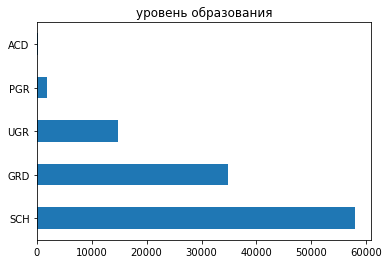

In [10]:
data['education'].value_counts().plot.barh(title = 'уровень образования')

Заполним самым популярным значением - 'SСH'

In [11]:
data['education'].fillna('SСH',inplace = True)

## 3. Анализ признаков

### Функции

In [12]:
# Проверка на выбросы
def show_outliers(column):
    col = data[column]
    IQR = col.quantile(0.75) - col.quantile(0.25)
    perc25 = col.quantile(0.25)
    perc75 = col.quantile(0.75)

    quan_low_outliers = len(data.query(f'{column} < {perc25 - 1.5*IQR}'))
    quan_high_outliers = len(data.query(f'{column} > {perc75 + 1.5*IQR}'))

    proc_low_outliers = round(quan_low_outliers/len(col) * 100,2) 
    proc_high_outliers = round(quan_high_outliers/len(col) * 100,2)

    print('Колонка',column)
    print(f'Количество выбросов ниже нижней границы: {quan_low_outliers} ({proc_low_outliers}%)')
    print(f'Количество выбросов выше верхней границы: {quan_high_outliers} ({proc_high_outliers}%)')
    print('\n')

#временная трансформация education в числовой признак
def transform_to_int(x):
    if x == 'SCH':
        return 1
    elif x == 'GRD':
        return 2
    elif x == 'UGR':
        return 3
    elif x == 'PGR':
        return 4
    elif x == 'ACD':
        return 5
    else:
        return 0
    
#Чтобы не было ошибки, во временном датасете преобразуем категориальные и бинарные признаки в числовые. Делаем в отдельной функции,чтобы не хранить в оперативной памяти копию датасета.Либо можно воспользовать командой del
def show_mutual_info(data):
    data_temp = data.copy()
    
    label_encoder = LabelEncoder()    
    for column in bin_cols:
        data_temp[column] = label_encoder.fit_transform(data_temp[column])
    
    data_temp['education'] = data_temp['education'].apply(transform_to_int)

    imp_cat = pd.Series(mutual_info_classif(data_temp.query('sample == 1')[cat_cols + bin_cols], data_temp.query('sample == 1')['default'],
                                     discrete_features =True), index = cat_cols + bin_cols)
    imp_cat.sort_values(inplace = True)
    imp_cat.plot(kind = 'barh', title = 'Значимость категориальных и бинарных признаков')

### Временные признаки

In [13]:
#переведём колонку в формат datetime
data['app_date'] = pd.to_datetime(data['app_date'])

In [14]:
print(data['app_date'].min(),data['app_date'].max())

2014-01-01 00:00:00 2014-04-30 00:00:00


Добавим признак количество дней от даты начала регистрации заявок

In [15]:
data['days'] = (data['app_date'] - data['app_date'].min()).dt.days.astype('int64') #доп колонка по дням улучшает ROC-AUC на 0.003

In [16]:
#Удалим признак app_date
data.drop('app_date',axis = 1, inplace=True)

### Категориальные и бинарные признаки

Оценим значимость категориальных и бинарных признаков

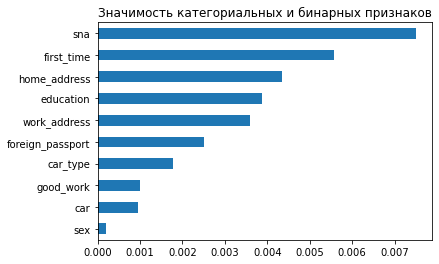

In [17]:
show_mutual_info(data)

Самым значимым из категориальных и бинарных признаков по mutual_info_classif является sna. Наименее значимым: sex.

### Числовые признаки

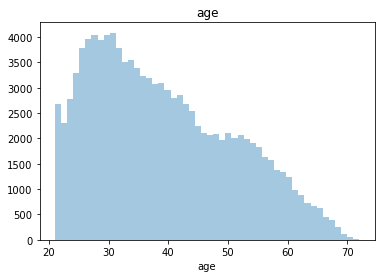

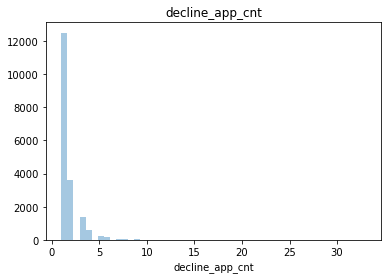

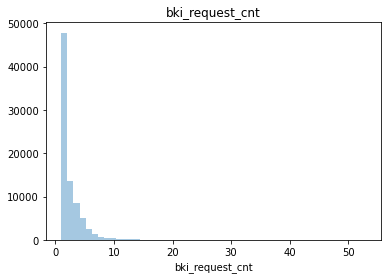

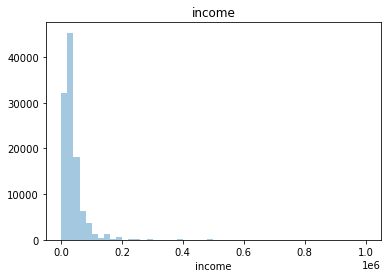

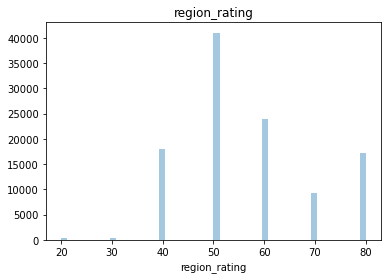

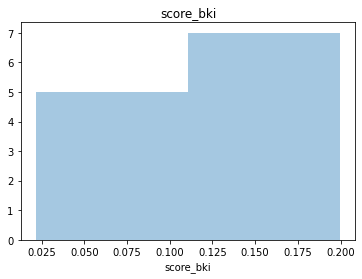

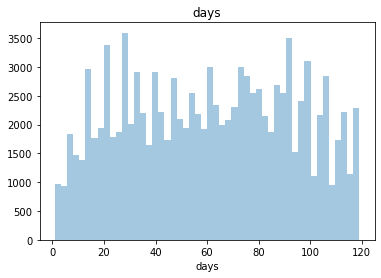

In [18]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0], kde = False, rug=False)
    plt.title(i)
    plt.show()

После построения гистограмм стало очевидно, что распределения почти всех числовых переменных имеют тяжёлый правый хвост

Логарифмируем числовые признаки, у которых неравномерное распределение

In [19]:
num_cols_log = ['age','decline_app_cnt','bki_request_cnt','income']

for column in num_cols_log:
    if len(data[column][data[column] < 0]) == 0:
        data[column] = np.log(data[column] + 1)

Построим boxplot’ы

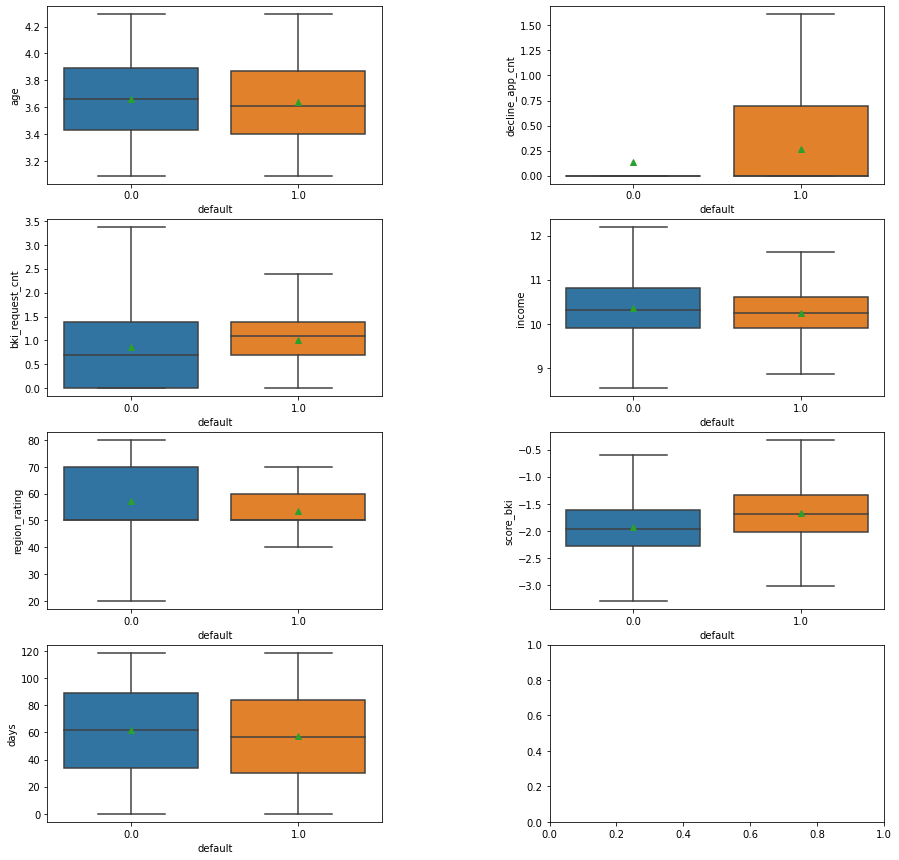

In [20]:
fig, axes = plt.subplots(4, 2, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()
for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data, orient = 'v',showmeans=True, ax=axes[i], showfliers=False)

In [21]:
# Описание признаков:

# client_id - идентификатор клиента  
# education - уровень образования  
# sex - пол заемщика  
# age - возраст заемщика  
# car - флаг наличия автомобиля  
# car_type - флаг автомобиля иномарки  
# decline_app_cnt - количество отказанных прошлых заявок  
# good_work - флаг наличия “хорошей” работы  
# bki_request_cnt - количество запросов в БКИ  
# home_address - категоризатор домашнего адреса  
# work_address - категоризатор рабочего адреса  
# income - доход заемщика  
# foreign_passport - наличие загранпаспорта  
# sna - связь заемщика с клиентами банка  
# first_time - давность наличия информации о заемщике  
# score_bki - скоринговый балл по данным из БКИ  
# region_rating - рейтинг региона  
# app_date - дата подачи заявки  
# default - флаг дефолта по кредиту

- Дефолтные клиенты в среднем младше  
- Дефолтные клиенты в среднем имеют большее количество отказанных заявок в прошлом
- Дефолтные клиенты в среднем имеют большее количество запросов в БКИ
- Дефолтные клиенты в среднем имеют меньше доход
- Дефолтные клиенты в среднем имеют меньший рейтинг региона
- Дефолтные клиенты в среднем имеют больший скоринговый балл по данным из БКИ 

Оценим значимость числовых признаков

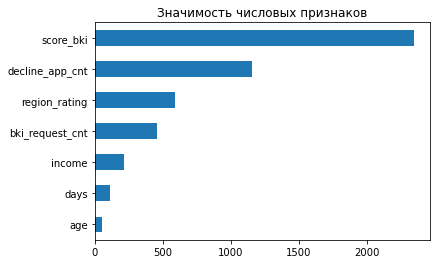

In [22]:
imp_num = pd.Series(f_classif(data.query('sample == 1')[num_cols], data.query('sample == 1')['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title = 'Значимость числовых признаков')

Самыми значимыми из числовых признаков по f_classif является skore_bki. Наименее значимым: age.

Проверим на выбросы

In [23]:
for column in num_cols:
    show_outliers(column)

Колонка age
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 0 (0.0%)


Колонка decline_app_cnt
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 18677 (16.96%)


Колонка bki_request_cnt
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 15 (0.01%)


Колонка income
Количество выбросов ниже нижней границы: 875 (0.79%)
Количество выбросов выше верхней границы: 1734 (1.57%)


Колонка region_rating
Количество выбросов ниже нижней границы: 747 (0.68%)
Количество выбросов выше верхней границы: 17170 (15.59%)


Колонка score_bki
Количество выбросов ниже нижней границы: 82 (0.07%)
Количество выбросов выше верхней границы: 436 (0.4%)


Колонка days
Количество выбросов ниже нижней границы: 0 (0.0%)
Количество выбросов выше верхней границы: 0 (0.0%)




В целом выбросов не так много. Максимальные выбросы в признаке decline_app_cnt(16.96%). Удалять не будем.Посмотрим,как отработает модель.

Посмотрим корреляцию

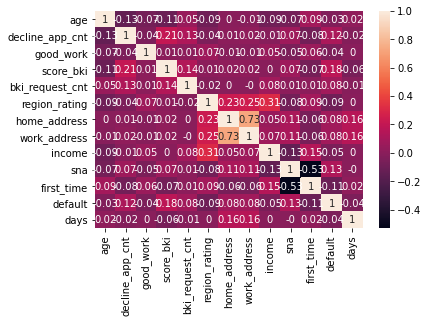

In [24]:
sns.heatmap(round(data.drop(['sample','client_id'],axis=1).corr(),2),annot=True)

Низкая корреляция признаков.Их можно использовать в модели.   
Значительной корреляции признаков с целевой переменной нет.

## 4. Feature Engineering

Добавим новый признак "Количество отказанных заявок 0". (улучшил ROC-AUC на 0.0015)

In [25]:
data['decline_app_cnt_0'] = (data['decline_app_cnt'] == 0).astype('uint8')

Добавим новый признак "Высокий рейтинг региона"

In [26]:
data['region_rating_high'] = (data['region_rating'] >= 60).astype('uint8')

Добавим dummy переменные для категориальных признаков (улучшает ROC-AUC на 0.08)

In [27]:
data = pd.get_dummies(data,columns=cat_cols)

Разобьем бинарные признаки на 0 и 1 (улучшает ROC-AUC на 0.004)

In [28]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

Стандартизируем числовые признаки (улучшает ROC-AUC на 0.15)

In [29]:
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols].values),columns=num_cols)

## Корреляция модифицированных признаков

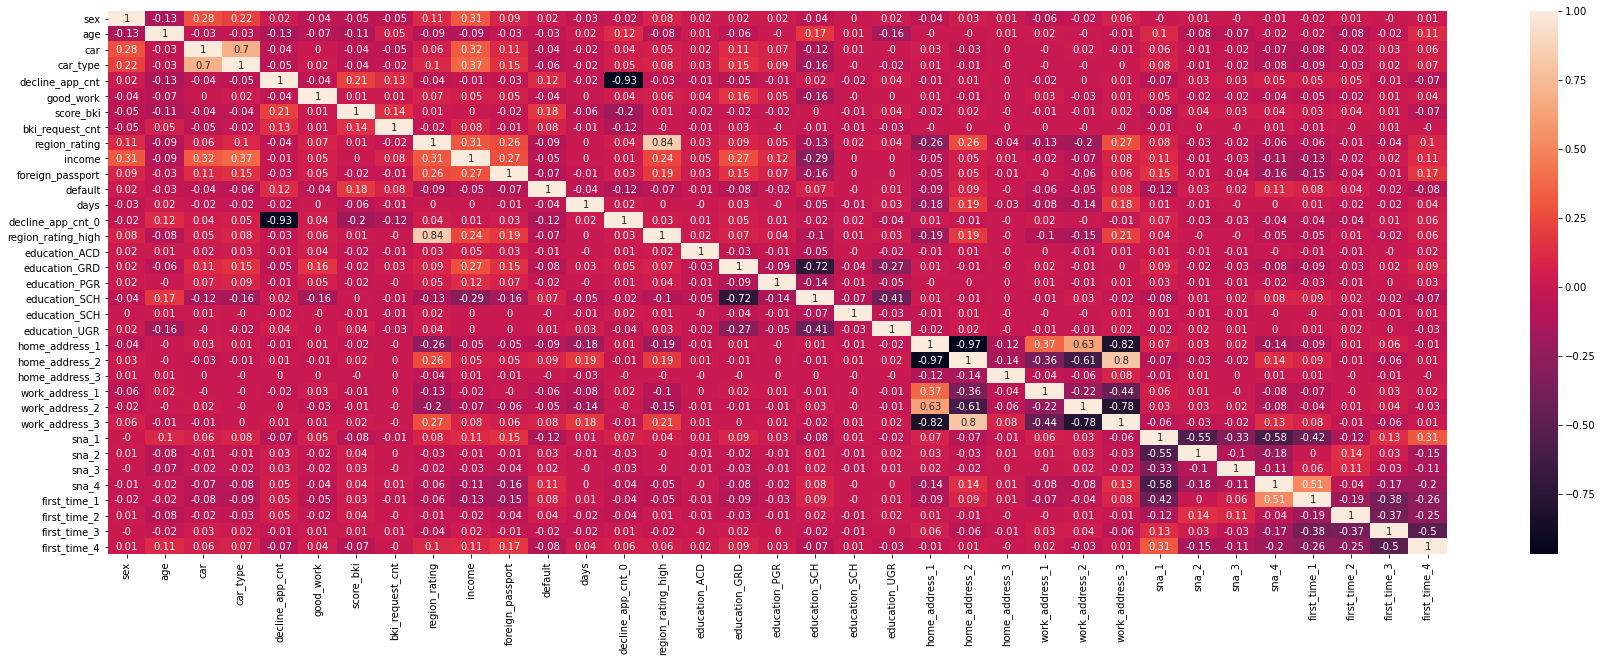

In [30]:
plt.rcParams['figure.figsize'] = (30,10)
sns.heatmap(round(data.drop(['sample','client_id'],axis=1).corr(),2),annot=True)
plt.rcParams['figure.figsize'] = (10,5)

У home_address_1 сильная корреляция с work_address_3 и home_address_2.(-0.97) Можно было бы удалить home_address_1, это не повлияло бы на значение ROC-AUC,но уменьшило бы нагрузку при вычислениях.Правда после этого возрастает ошибка 1-го рода (значение FP в confusion matrix) и уменьшается TP. Поэтому не будем удалять признак home_address_1.   
Остальные признаки не сильно коррелированы между собой,поэтому их можно использовать в модели.   
Значительной корреляции признаков с целевой переменной нет.

In [31]:
#data.drop(['home_address_1'],axis=1,inplace=True)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [32]:
# на всякий случай, заново подгружаем данные
DATA_DIR = '../input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

#Для удобства выделим категориальные,бинарные и числовые признаки в отдельные колонки
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time'] #категориальные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work'] #бинарные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'region_rating', 'score_bki', 'days'] #числовые

In [33]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    # ################### NAN ############################################################## 
    df_output['education'].fillna('SCH', inplace=True)
    
    # ################### Feature Engineering ####################################################
    df_output['app_date'] = pd.to_datetime(df_output['app_date'])
    df_output['days'] = (df_output['app_date'] - df_output['app_date'].min()).dt.days.astype('int64')
    df_output.drop('app_date',axis = 1, inplace=True)
    
    df_output['decline_app_cnt_0'] = (df_output['decline_app_cnt'] == 0).astype('uint8')
    df_output['region_rating_high'] = (df_output['region_rating'] >= 60).astype('uint8')
    
    # ################### Encoding ##############################################################
    label_encoder = LabelEncoder()
    for column in bin_cols:
        df_output[column] = label_encoder.fit_transform(df_output[column])
        
    df_output = pd.get_dummies(df_output,columns=cat_cols)   

    num_cols_log = ['age','decline_app_cnt','bki_request_cnt','income']
    for column in num_cols_log:
        if len(data[column][data[column] < 0]) == 0:
            data[column] = np.log(data[column] + 1)
            
    num_col_resid = list(set(num_cols) - set(num_cols_log))
            
    df_output[num_col_resid] = pd.DataFrame(StandardScaler().fit_transform(df_output[num_col_resid].values),columns=num_col_resid)
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    #df_output.drop(['home_address_1'],axis=1,inplace=True)
     
    return df_output

In [34]:
df_preproc = preproc_data(data)

In [35]:
df_preproc = preproc_data(data)

# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample','default'], axis=1)

X = train_data.drop(['default','client_id'], axis=1)
y = train_data['default'].values

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 34), (73799, 35), (73799, 33), (59039, 33), (14760, 33))

# Model

## 1. Функции

In [56]:
#Вывод понятной confusion_matrix
def confusion_matrix_f(d_name_columns, y_true, y_pred,title='Матрица ошибок'):
  
    classes  = np.array(d_name_columns, dtype = 'U10')
    list_of_labels = [['TP','FP'],['FN','TN']]
    
    cm = confusion_matrix(y_true, y_pred)

    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]

    plt.style.use('seaborn-paper')
    cmap=plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title)
    
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Актуальные значения', fontsize=14, color = color_text)
    ax.set_xticklabels(classes, fontsize=12, color = 'black')
    ax.set_yticklabels(classes, fontsize=12, color = 'black')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j]+'\n'+format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

#Вывести метрики
def all_metrics(y_true, y_pred, y_probs):
    
    metrics_dict = {}
    metrics_dict['accuracy'] = [accuracy_score(y_true, y_pred),'(TP+TN)/(P+N)']
    metrics_dict['precision'] = [precision_score(y_true, y_pred),'точность TP/(TP+FP)']
    metrics_dict['recall'] = [recall_score(y_true, y_pred),'полнота TP/(TP+FN)']
    metrics_dict['f1_score'] = [f1_score(y_true, y_pred),'2*(precision*recall)/(precision+recall)']
    metrics_dict['roc_auc'] = [roc_auc_score(y_true, y_probs),'roc_auc']

    df_tmp = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Значение','Описание'])
    display(df_tmp)

#Вывести всё
def show_all(y_test,y_pred,y_probs,title = 'LogisticRegression'):
    
    fpr, tpr, threshold = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    
    plt.rcParams['figure.figsize'] = (10,5)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title(f'{title} ROC AUC = %0.4f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

    all_metrics(y_test,y_pred,y_probs)
    confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 'Матрица ошибок')

## 2.Реализация

Воспользуемся различными моделями и усредним их ответы

In [37]:
import lightgbm as lgb
from catboost import CatBoostClassifier

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)[:, 1]


gbm = lgb.LGBMClassifier()
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
        early_stopping_rounds=5
       )
gbm_probs = gbm.predict_proba(X_test)[:, 1]


cat = CatBoostClassifier(random_seed=RANDOM_SEED,silent=True)
cat.fit(X_train,y_train)
cat_probs = cat.predict_proba(X_test)[:, 1]

models = []
models.append(lr)
models.append(gbm)
models.append(cat)

[1]	valid_0's auc: 0.70369	valid_0's binary_logloss: 0.368268
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.709632	valid_0's binary_logloss: 0.363461
[3]	valid_0's auc: 0.715715	valid_0's binary_logloss: 0.359555
[4]	valid_0's auc: 0.71668	valid_0's binary_logloss: 0.356324
[5]	valid_0's auc: 0.719312	valid_0's binary_logloss: 0.353628
[6]	valid_0's auc: 0.722024	valid_0's binary_logloss: 0.351234
[7]	valid_0's auc: 0.72376	valid_0's binary_logloss: 0.349382
[8]	valid_0's auc: 0.724988	valid_0's binary_logloss: 0.347732
[9]	valid_0's auc: 0.72605	valid_0's binary_logloss: 0.346362
[10]	valid_0's auc: 0.72801	valid_0's binary_logloss: 0.344979
[11]	valid_0's auc: 0.728802	valid_0's binary_logloss: 0.343978
[12]	valid_0's auc: 0.730163	valid_0's binary_logloss: 0.342867
[13]	valid_0's auc: 0.731296	valid_0's binary_logloss: 0.341851
[14]	valid_0's auc: 0.732794	valid_0's binary_logloss: 0.340993
[15]	valid_0's auc: 0.732823	valid_0's binary_logloss: 0.3

In [150]:
#Усредним ответы
y_probs = np.zeros(len(X_test))
y_pred = None

for model in models:
    y_probs += model.predict_proba(X_test)[:, 1]
    
    pred = model.predict(X_test)
    if y_pred is None:
        y_pred = np.vstack([pred])
    else:
        y_pred = np.vstack([y_pred,pred])
    
y_probs = y_probs/len(models)

y_pred = np.array(pd.DataFrame(y_pred).agg(['mode']))
y_pred = y_pred.reshape(y_pred.shape[1],y_pred.shape[0])

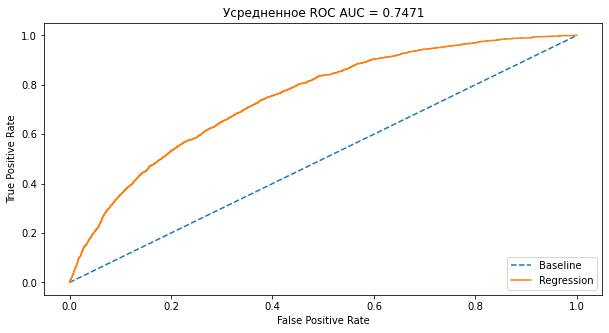

,Значение,Описание
accuracy,0.875474,(TP+TN)/(P+N)
precision,0.417910,точность TP/(TP+FP)
recall,0.015326,полнота TP/(TP+FN)
f1_score,0.029567,2*(precision*recall)/(precision+recall)
roc_auc,0.747076,roc_auc


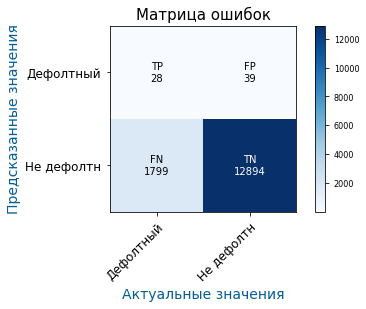

In [152]:
show_all(y_test,y_pred,y_probs,title = 'Усредненное')

# Submission

In [154]:
test_data_2 = test_data.drop('client_id', axis=1)
y_pred_probs = np.zeros(len(test_data_2))

for model in models:
    y_pred_probs += model.predict_proba(test_data_2)[:, 1]
    
y_pred_probs = y_pred_probs / len(models)

submit = pd.DataFrame({'client_id': test_data['client_id'], 'default': y_pred_probs})
   
print(submit.shape)
submit.head(5)

(36349, 2)


,client_id,default
0,74835,0.036002
1,17527,0.361874
2,75683,0.077318
3,26883,0.077491
4,28862,0.021488


In [155]:
submit.to_csv('submission.csv', index=False)